# CSCI 4022 Final Project: Movie Recommendation with K-Means

## Kate McCarthy and Téa Wright

This notebook includes the code for a user-based movie recommendation system by clustering on keyword rating.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from ast import literal_eval
from sklearn.cluster import KMeans

Since, the datasets for keywords and metadata have close to 50,000 rows and the ratings has 26 million, Pandas will have better performance than Numpy, so we are loading the data in as Pandas dataframes. 

In [2]:
# load in data as csv -- should we use numpy or pandas?
keywords = pd.read_csv('data/keywords.csv')
metadata = pd.read_csv('data/movies_metadata.csv')
ratings = pd.read_csv('data/ratings_small.csv')

/Users/teaywright/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
print("Keywords shape:",keywords.shape)
print("Metadata shape:",metadata.shape)
print("Ratings shape:",ratings.shape)

Keywords shape: (46419, 2)
Metadata shape: (45466, 24)
Ratings shape: (100004, 4)


In [4]:
# test cells -- making sure data sets are comparable sizes and look right
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [5]:
metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [7]:
#make sure keywords and ratings have the same movies included -- takes size down by a lot

keywords = keywords.rename(columns={"id": "movieId", "keywords": "keywords"})
merged_df = pd.merge(keywords, ratings, on='movieId', how='inner')
ratings = merged_df.drop(columns = 'keywords')
ratings.head()

,movieId,userId,rating,timestamp
0,949,23,3.5,1148721092
1,949,102,4.0,956598942
2,949,232,2.0,955092697
3,949,242,5.0,956688825
4,949,263,3.0,1117846575


In [8]:
#Included movies -- decrease data size to 10000 ish

included_movieIds_tmp = []

for movieId in ratings['movieId']:
    included_movieIds_tmp.append(movieId)

included_movieIds = list(set(included_movieIds_tmp))

#make alphabetical
included_movieIds = sorted(included_movieIds)

print("Number of unique movies:",len(included_movieIds))
print(included_movieIds[:10])

Number of unique movies: 2830
[2, 3, 5, 6, 11, 12, 13, 14, 15, 16]


In [9]:
print("Keywords shape:",keywords.shape)
print("Metadata shape:",metadata.shape)
print("Ratings shape:",ratings.shape)

Keywords shape: (46419, 2)
Metadata shape: (45466, 24)
Ratings shape: (45010, 4)


In [10]:
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #crop at 3 keywords -- maybe make less
        if len(names) > 5:
            names = names[:5]
        return names
    return []

keywords['keywords'] = keywords['keywords'].apply(literal_eval)
keywords['keywords'] = keywords['keywords'].apply(get_list)

#cleaning lowercase, spaces, etc?

In [11]:
keywords.head()

,movieId,keywords
0,862,"[jealousy, toy, boy, friendship, friends]"
1,8844,"[board game, disappearance, based on children'..."
2,15602,"[fishing, best friend, duringcreditsstinger, o..."
3,31357,"[based on novel, interracial relationship, sin..."
4,11862,"[baby, midlife crisis, confidence, aging, daug..."


In [12]:
#get unique keywords

master_keyword_list = []

for keywords_list in keywords['keywords']:
    master_keyword_list.append(keywords_list)
    
tmp = [item for sublist in master_keyword_list for item in sublist]
unique_keywords = list(set(tmp))

#make alphabetical
unique_keywords = sorted(unique_keywords)

print("Number of unique keywords:",len(unique_keywords))
print("First 10 keywords:", unique_keywords[:10])

Number of unique keywords: 13250
First 10 keywords: ["'comfort women'", '077', '10th century', '15th century', '16th century', '17th century', '18th century', '1910s', '1920s', '1930s']


In [13]:
#function to go from arr index to keyword string
def idx_to_keyword(idx):
    return unique_keywords[idx]
def keyword_to_idx(keyword):
    return unique_keywords.index(keyword)

In [14]:
#test idx_to_keyword and keyword_to_idx
idx_to_keyword(3)
keyword_to_idx('romance')

10024

In [15]:
#find number of users
master_user_list = []

for user in ratings['userId']:
    if user in master_user_list:
        continue
    master_user_list.append(user)


unique_users = list(set(master_user_list))
unique_users = sorted(unique_users)

print("Number of unique users:",len(unique_users))
print(unique_users[:10])

Number of unique users: 671
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [16]:
#initialize np array to hold samples x features where features are each keyword and samples are users
#each value in the arr is a user rating
#add 1 so no 0-indexing
keywords_ratings = np.zeros((len(unique_users)+1,len(unique_keywords)+1))
counts = np.zeros((len(unique_users)+1,len(unique_keywords)+1))


In [17]:
#populate array

for user_id in unique_users: #for each user
    print("User ID:",user_id)

    for movie_id in included_movieIds: #for each movie 
        #skip if the user hasn't rated the movie
        rating = ratings.loc[(ratings['movieId'] == movie_id) & (ratings['userId'] == user_id)]['rating'].tolist()
        
        if rating == []:
            continue
        else:
            rating = rating[0]

        
        #for keywords related to that movie
        keywords_list = keywords.loc[keywords['movieId'] == movie_id]['keywords'].tolist()[0]
        
        for keyword in keywords_list:
            #print("Keyword:",keyword)
            keyword_idx = keyword_to_idx(keyword)
            
            #update avearge score for that keyword for that user
            #print("Previous Arr Entry:",keywords_ratings[user_id][keyword_idx])
            counts[user_id][keyword_idx] += 1
            keywords_ratings[user_id][keyword_idx] = rating + (counts[user_id][keyword_idx] - 1)*keywords_ratings[user_id][keyword_idx]
            keywords_ratings[user_id][keyword_idx] /= counts[user_id][keyword_idx]   
            #print("Updated Arr Entry:", keywords_ratings[user_id][keyword_idx])


User ID: 1
User ID: 2
User ID: 3
User ID: 4
User ID: 5
User ID: 6
User ID: 7
User ID: 8
User ID: 9
User ID: 10
User ID: 11
User ID: 12
User ID: 13
User ID: 14
User ID: 15
User ID: 16
User ID: 17
User ID: 18
User ID: 19
User ID: 20
User ID: 21
User ID: 22
User ID: 23
User ID: 24
User ID: 25
User ID: 26
User ID: 27
User ID: 28
User ID: 29
User ID: 30
User ID: 31
User ID: 32
User ID: 33
User ID: 34
User ID: 35
User ID: 36
User ID: 37
User ID: 38
User ID: 39
User ID: 40
User ID: 41
User ID: 42
User ID: 43
User ID: 44
User ID: 45
User ID: 46
User ID: 47
User ID: 48
User ID: 49
User ID: 50
User ID: 51
User ID: 52
User ID: 53
User ID: 54
User ID: 55
User ID: 56
User ID: 57
User ID: 58
User ID: 59
User ID: 60
User ID: 61
User ID: 62
User ID: 63
User ID: 64
User ID: 65
User ID: 66
User ID: 67
User ID: 68
User ID: 69
User ID: 70
User ID: 71
User ID: 72
User ID: 73
User ID: 74
User ID: 75
User ID: 76
User ID: 77
User ID: 78
User ID: 79
User ID: 80
User ID: 81
User ID: 82
User ID: 83
User ID: 84
U

User ID: 640
User ID: 641
User ID: 642
User ID: 643
User ID: 644
User ID: 645
User ID: 646
User ID: 647
User ID: 648
User ID: 649
User ID: 650
User ID: 651
User ID: 652
User ID: 653
User ID: 654
User ID: 655
User ID: 656
User ID: 657
User ID: 658
User ID: 659
User ID: 660
User ID: 661
User ID: 662
User ID: 663
User ID: 664
User ID: 665
User ID: 666
User ID: 667
User ID: 668
User ID: 669
User ID: 670
User ID: 671


In [22]:
#checking
keywords_ratings = keywords_ratings.astype(int)
print(keywords_ratings.shape)
print(np.count_nonzero(keywords_ratings))

(672, 3479)
150447


In [23]:
#delete all-zero columns
keywords_ratings = keywords_ratings[:,~np.all(keywords_ratings == 0, axis = 0)]
print(keywords_ratings.shape)

(672, 3479)


In [24]:
#cluster users test
kmeans = KMeans(n_clusters=20, random_state=0)
assignments = kmeans.fit_predict(keywords_ratings, y=None, sample_weight=None)
score = kmeans.score(keywords_ratings)

In [25]:
print("User cluster assignments:", assignments)

User cluster assignments: [12 12 19  7 16  7 12 14  7 12 12 12 12 12 12  9 12 10  1  3 14  6  7  2
 14  1 11 12  7 12  8  7 14  7 16 12  6 12  7 14 12  7  7  7  1 12 12 14
 11  7 14 12 12 12 12  1 16 16 12  7  7  7 12  7 14 12  7 19  7  7  1 12
 11 13  7  7 12 16 11 12  1  7 14  7  7 19  6  1 16  7  1  7 19  6 11 16
 12  7 12 16  1 12  8  7 12  5 12 12 14 12 19  5  1  1 14  7 12 12  4  8
  7 19 14 12  7 16 14 12 15 12 16 12 12 12 16 12 12  7 12 12 12 12 12  7
 14 14  7 12  7  7 15 19 11  7  1  7 12 11 12  6  7 19  1  7  7 16 12 12
  6 12 12 12 14  1 12  7  7  3  7 12 12 12 19 12 14 16 12  4 19  7 12 14
 14  7 14 10 12  7 12 11  7  6 12 12 12  7 12 12 12 12 12  1 15 16 16  7
  7  7 12  4 16 12 12  1  6 14 12 12 12 12  7 12  8  1  7  5 10  7 12  4
  4 14  8 16  7  7 12 16  7 12  7  7  1 16 19  7  1  7 12 12 12 14  4  7
 12 10 14 12 16 12  7  7 12  7 12  7 12 12 12 14 12  7  7 11  1 16 12  4
 19 12  7  7  5  7 18  5 12  7  7  4 12 12 14 16  7 12  8  7 14  7 12  3
 16 15 12 12 12 14  1 14 

In [33]:
#finding optimal number of clusters

scores = []
k_range = (np.linspace(2,50,25)).astype(int)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    assignments = kmeans.fit_predict(keywords_ratings, y=None, sample_weight=None)
    score = - kmeans.score(keywords_ratings) #k-means objective
    print("num clusters:",k,"score:",score)
    scores.append(score)
    

num clusters: 2 score: 1341476.2624080891
num clusters: 4 score: 1239231.6859721746
num clusters: 6 score: 1198408.5707886522
num clusters: 8 score: 1171438.4171801168
num clusters: 10 score: 1154268.6504219053
num clusters: 12 score: 1136478.5897941634
num clusters: 14 score: 1114390.7117264443
num clusters: 16 score: 1111739.8677884068
num clusters: 18 score: 1100117.9629652442
num clusters: 20 score: 1092648.2027871108
num clusters: 22 score: 1076541.1312076151
num clusters: 24 score: 1064554.7157657014
num clusters: 26 score: 1053974.137691545
num clusters: 28 score: 1048754.759869162
num clusters: 30 score: 1035385.046757205
num clusters: 32 score: 1034237.4941261814
num clusters: 34 score: 1021221.3996555676
num clusters: 36 score: 1012645.6239077596
num clusters: 38 score: 998540.8635668572
num clusters: 40 score: 995834.5590226621
num clusters: 42 score: 988958.7419406088
num clusters: 44 score: 977596.7410410624
num clusters: 46 score: 969542.4832635192
num clusters: 48 score:

Text(0, 0.5, 'SSE')

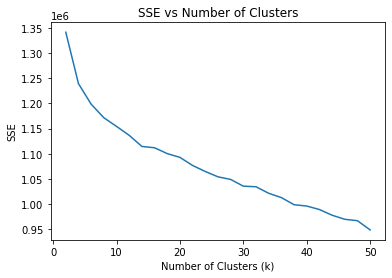

In [47]:
plt.plot(k_range,scores)
plt.title("SSE vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("SSE")

In [51]:
#optimal clustering
kmeans = KMeans(n_clusters=15, random_state=0)
assignments = kmeans.fit_predict(keywords_ratings, y=None, sample_weight=None)

In [52]:
print(assignments)

[ 6  6  3 12  7  4  6  0 14  6  6  6  6  6  6  9  6  1 11 13  0  7 14  9
  2 11 12  6  4  6  8 12  2  6  7  6  3  6 12  2  6  0 14  4 11  6  6  2
 14  0  2  6  6  6  6 11  1  7  6 12 12  5  6 12  2  6  6  3  0  5 11  6
 12 10  6  0  6  1  1  6 11  4  2  4  5  3  3 11  1 14 11 14  3  7 14  7
  4 12  6  7 11  6 13  5  6  1  6  6  2 12  3  1 11 11  2 12  6  6  7  8
 14  3  2  6 14  1  2  6 10  6  1  6  6  5  1  6  5  0 12  6  6  6  6 12
  2  2 14 12  0 12 10  2 14 12 11  4  6 14  6  7  4  3 11 14 12 10  6  6
  3  5  6 12  2 11  6  5  5 10 12  6  6  6  3 12  2  7  6  1  3  4  6  2
  2  4  2 13  6  0  4  1 14 14  6  6  6  5  6  6  6  6  6 11 10 10  7  4
 12  0 12  1  1  6  6 11  3  2  6  6  6  6 12  6  8 11  5  1  4 12  6  7
  1  2 13  1  5 14  6 10  0  6 14  5 11  1  3  4 11 12  6  6  6  2  1 12
  6  7  2 12  1  6 12 14  6  5 12 14  6  6  4  2  6  4 14 14 11 10  6  0
  3  6  6 12  1  5  9  1  6 12  5  4  6  6  2  1 12  6 10 12  2 12  6 13
  7  1  6  6  5  2 11  6  6  4  6  6 14  6  6  6  0

In [53]:
np.nonzero(keywords_ratings)

(array([  1,   1,   1, ..., 671, 671, 671]),
 array([ 370,  371,  540, ..., 3417, 3450, 3451]))

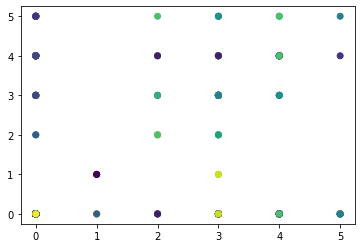

In [54]:
#visualize on 2 axes
plt.scatter(keywords_ratings[:,370], keywords_ratings[:,371], c = assignments)

Visualization with so many dimensions is not very helpful.

The following code is sanity checking that the users clustered together do have similar tastes (in my opinion, as it is difficult to do quantitatively at this scale). However, this sanity check does not include what they may have disliked or rated mediocre.

In [55]:
#both in cluster 0
user1 = ratings.loc[(ratings['userId']==9) & (ratings['rating'] > 4.0)]
user2 = ratings.loc[(ratings['userId']==10) & (ratings['rating'] > 4.0)]
user1movieids = list(user1['movieId'])
user1movies = []
for movieid in user1movieids:
    user1movies.append(metadata.loc[metadata['id'] == str(movieid)]['original_title'])
    
user2movieids = list(user2['movieId'])
user2movies = []
for movieid in user2movieids:
    user2movies.append(metadata.loc[metadata['id'] == str(movieid)]['original_title'])
    
print("User 668 Top Rated Movies:", user1movies)
print("User 9 Top Rated Movies:", user2movies)

User 668 Top Rated Movies: [286    Once Were Warriors
Name: original_title, dtype: object, 5325    Men in Black II
Name: original_title, dtype: object, 5501    Mosura tai Gojira
Name: original_title, dtype: object, 7518    隠し砦の三悪人
Name: original_title, dtype: object, 13693    Terminator Salvation
Name: original_title, dtype: object]
User 9 Top Rated Movies: [3144    Twin Peaks: Fire Walk with Me
Name: original_title, dtype: object, 6631    A Brief History of Time
Name: original_title, dtype: object, 7414    La Peau douce
Name: original_title, dtype: object, 9744    The Three Musketeers
Name: original_title, dtype: object, 11023    Das Wunder von Bern
Name: original_title, dtype: object]


In [56]:
#both in cluster 9
user1 = ratings.loc[(ratings['userId']== 6) & (ratings['rating'] > 4.0)]
user2 = ratings.loc[(ratings['userId']== 21) & (ratings['rating'] > 4.0)]

user1movieids = list(user1['movieId'])
user1movies = []
for movieid in user1movieids:
    user1movies.append(metadata.loc[metadata['id'] == str(movieid)]['original_title'])
    
user2movieids = list(user2['movieId'])
user2movies = []
for movieid in user2movieids:
    user2movies.append(metadata.loc[metadata['id'] == str(movieid)]['original_title'])
    
print("User 2 Top Rated Movies:", user1movies)
print("User 7 Top Rated Movies:", user2movies)

User 2 Top Rated Movies: [1498    My Best Friend's Wedding
Name: original_title, dtype: object, 2102    Secret Agent
Name: original_title, dtype: object, 2983    A River Runs Through It
Name: original_title, dtype: object, 11481    Notes on a Scandal
Name: original_title, dtype: object, 11592    Ghost Rider
Name: original_title, dtype: object, 24283    Torrente 3: El protector
Name: original_title, dtype: object]
User 7 Top Rated Movies: [286    Once Were Warriors
Name: original_title, dtype: object, 1236    The Great Dictator
Name: original_title, dtype: object, 2649    The Thomas Crown Affair
Name: original_title, dtype: object, 7234    Dawn of the Dead
Name: original_title, dtype: object, 8546    Murder She Said
Name: original_title, dtype: object, 10089    Madagascar
Name: original_title, dtype: object, 18256    Je vais bien, ne t'en fais pas
Name: original_title, dtype: object]


In [88]:
#recommender function -- get 5 star movies of similar users

def getRecommendations(user,assignments):
    user_assignment = assignments[user]
    similar_users = []
    for idx, value in enumerate(assignments):
        if value == user_assignment:
            similar_users.append(idx)
    similar_users.remove(user)
    movies = []
    for sim_user in similar_users:
        toprated = ratings.loc[(ratings['userId']== sim_user) & (ratings['rating'] == 5.0)]
        movieids = list(toprated['movieId'])
        for movieid in movieids:
            title = str(metadata.loc[metadata['id'] == str(movieid)]['original_title'].values[0])
            if title in movies: continue #ignore repeats
            movies.append(title)
    print("Based on your ratings, similar users enjoyed the following movies!")
    return movies

In [92]:
#test recommendation

getRecommendations(200,assignments)

Based on your ratings, similar users enjoyed the following movies!


['Once Were Warriors',
 'Sleepless in Seattle',
 'Blackmail',
 'The Million Dollar Hotel',
 'Fahrenheit 9/11',
 'The Bourne Supremacy',
 'My Name Is Bruce',
 'Shriek If You Know What I Did Last Friday the Thirteenth',
 'Carry On Doctor',
 'Der Tunnel',
 'The Poseidon Adventure',
 '5 Card Stud',
 'Terminator 3: Rise of the Machines',
 'La belle et la bête',
 'The Goddess',
 'Monsoon Wedding',
 'Sissi',
 'A River Runs Through It',
 'Sous le Sable',
 'License to Wed',
 'Trois couleurs : Rouge',
 'The 39 Steps',
 'Reservoir Dogs',
 'Batman Returns',
 'Young and Innocent',
 'Say Anything...',
 'The Hours',
 'Bang Boom Bang - Ein todsicheres Ding',
 'Muxmäuschenstill',
 'City of Hope',
 'Syriana',
 'No Reservations',
 'No mires para abajo',
 'Confession of a Child of the Century',
 'Klute',
 'The Searchers',
 'And Then There Were None',
 'Mosura tai Gojira',
 'Bridge to Terabithia',
 'Brake',
 'Haker',
 'The Chronicles of Riddick: Dark Fury',
 'Boogie Nights',
 'Солярис',
 '48 Hrs.',
 'Local